# Machine learning pipeline

## Set your working directory to the root folder of the repository (ML_spring_2019) on your computer

In [ ]:
os.chdir("C:\\Users\\edwar.WJM-SONYLAPTOP\\Documents\\GitHub\\ML_spring_2019")

## Load packages

In [ ]:
'''
Machine learning HW 2
Spring 2019
pete rodrigue
'''

import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn import tree
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
import pylab
import scipy.stats as stats

## Define all our functions

In [52]:
def load_and_peek_at_data(path, summary=False):
    '''
    Loads our data and returns a pandas dataframe.
    This function also saves a csv file with descriptive statistics for all
    our variables to our figures folder.
    '''
    separator = '************************\n************************\n\n'
    df = pd.read_csv(path)
    print(separator)
    print('Head of data:')
    print(df.head(5))
    print(separator)
    print('Tail of data:')
    print(df.tail(5))
    print(separator)
    print('column names of data:')
    print(df.columns)
    print(separator)
    print('number of rows of data:')
    print(len(df))
    print(separator)

    if summary:
        print("\n\n\nSummary of data:")
        print(df.describe())
        df.describe().to_csv('exercise two/figures/summary.csv')

    return df


def make_graphs(df, normal_qq_plots=False):
    '''
    Takes our dataframe, fills in missing values with the median,
    and outputs a series of plots:
            - Normal qq plots for each variable
            - Boxplots for each variable
            - Histograms for each variable
        - A correlation plot for all our variables

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    df_temp = df._get_numeric_data()
    fill_missing(df_temp)
    g = sns.heatmap(df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])].corr())
    plt.savefig('exercise two/figures/correlation_plot')
    plt.close()
    for col in df_temp.columns:
        plt.clf()
        mycol = df_temp[col][df_temp[col].notna()]
        print('skew', ' for col ', mycol.name, 'is:', mycol.skew())
        if abs(mycol.skew()) > 10:
            path = "exercise two/figures/" + col + "log_transformed"
            g = sns.distplot(mycol)
            g.set_title(col + " dist, log_transformed")
            g.set(xscale='log')
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + \
                       " normal_qq_plot log trans"
                g = stats.probplot(np.log(df[col]+.0001),
                                   dist="norm", plot=pylab)
                plt.title(col + " normal_qq log transformed")
                plt.savefig(path)
        else:
            path = "exercise two/figures/" + col
            g = sns.distplot(mycol)
            g.set_title(col + " distribution")
            plt.savefig(path)
            plt.close()
            if normal_qq_plots:
                path = "exercise two/figures/" + col + " normal_qq_plot"
                g = stats.probplot(df[col], dist="norm", plot=pylab)
                plt.title(col + " normal_qq")
                plt.savefig(path)
        plt.clf()
        path = "exercise two/figures/" + col + " boxplot"
        g = sns.boxplot(mycol)
        plt.savefig(path)


def fill_missing(df):
    '''
    Fill missing numerica data in our data frame with the median value of that
    variable. Modifies the dataframe in place. Does not return anything.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
    '''
    for col in df.columns:
        if df[col].isna().any():
            median_val = df[col].median()
            df[col].fillna(median_val, inplace=True)


def descretize_var(df, var, num_groups):
    '''
    Takes one of our variables and splits it into discrete groupsself.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make a
                   categorical variable from
        num_groups (int): the number of groups our discrete variable will have

    Returns: a modified dataframe.
    '''
    labs = list(range(1, num_groups + 1))
    labs = [str(x) for x in labs]
    new_var = var + '_discrete'
    df[new_var] = pd.qcut(df[var], num_groups, labels=labs)

    return df


def make_dummies(df, var):
    '''
    Takes our dataframe and turns a specified variable into a series of
    dummy columns. This function returns the modified dataframe.

    Inputs:
        df (pandas dataframe): our dataframe we want to modify
        var (str): the column in our dataframe that we want to make dummies of

    Returns: a modified dataframe.
    '''
    new_var_prefix = "D_" + var

    return pd.concat([df, pd.get_dummies(df[var], prefix=new_var_prefix)],
                     axis=1)


def run_tree_model(df, x_data, y_data, max_depth, outcome_labels):
    '''
    This function takes our data and computes a decision tree model.
    It saves a .dot file you can open in graphviz to see the tree.
    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        max_depth (int): the maximum depth of the tree.
        outcome_labels (list of str): the labels for our predictor variables.
    '''
    model = tree.DecisionTreeClassifier(max_depth=5)
    model.fit(X=x_data, y=y_data)

    print('feature names:\n', x_data.columns)
    print('feature importances:\n', model.feature_importances_)
    print('score:\n', model.score(X=x_data, y=y_data))

    tree.export_graphviz(model,
                         out_file='exercise two/figures/tree.dot',
                         feature_names=x_data.columns,
                         class_names=outcome_labels,
                         filled=True)


def run_logit_model(x_data, y_data, threshold=.5):
    '''
    This function takes our x and y data and a threshold,
    and computes a logistic model. It exports a confusion matrix table.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        threshold (float): the threshold, between 0 and 1, that we'll use to
                           to decide if a given row is predicted to be a
                           positive in the target class or not.
    '''
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_data, y_data)

    predicted_probs = pd.DataFrame(logisticRegr.predict_proba(x_data))
    predicted_probs['predicted_class'] = 0
    predicted_probs.loc[predicted_probs[1] > threshold, 'predicted_class'] = 1
    cm = metrics.confusion_matrix(y_data, predicted_probs['predicted_class'])

    score = (cm[0][0] + cm[1][1]) / sum(sum(cm))

    plt.clf()
    g = sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5,
                    square=True, cmap='Blues_r')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    all_sample_title = 'Using {0} threshold, score is: {1}'.format(
                                                            threshold, score)
    plt.title(all_sample_title, size=15)
    plt.savefig('exercise two/figures/logistic_confusion_matrix')
    plt.clf()


def logit_try_diff_thresholds(x_data, y_data, step=.05):
    '''
    This function takes our x and y data and a step,
    and computes a series of logistic models, where the threshold increases
    by the amount given by the step each time.

    Inputs:
        x_data (pandas dataframe): data frame where each column is a predictor
        y_data (pandas series): series of outcomes
        step (float): the amount our threshold will increase each time.
    '''
    logisticRegr = LogisticRegression()
    logisticRegr.fit(x_data, y_data)
    predicted_probs = pd.DataFrame(logisticRegr.predict_proba(x_data))
    true_pos_correctly_id = []
    true_neg_correctly_id = []
    true_neg_incorrect_id = []

    for threshold in np.arange(0, 1.000001, step):
        predicted_probs['predicted_class'] = 0
        predicted_probs.loc[predicted_probs[1] > threshold,
                            'predicted_class'] = 1
        cm = metrics.confusion_matrix(y_data,
                                      predicted_probs['predicted_class'])
        score = (cm[0][0] + cm[1][1]) / sum(sum(cm))
        share_true_negatives = cm[0][0] / sum(cm[0])
        share_true_positives = cm[1][1] / sum(cm[1])
        share_false_negatives = cm[1][0] / sum(cm[0])
        share_false_positives = cm[0][1] / sum(cm[1])
        fpr = cm[0][1] / (sum(cm[0]))
        print("\nThreshold is: ", threshold, '\n',
              'Score is: ', score, '\n',
              'Percent true of negatives correctly identified: ',
              round(share_true_negatives*100, 2),
              '\nPercent of true positives erroneously labeled negative: ',
              round(share_false_negatives*100, 2),
              '\nPercent of true positives correctly identified: ',
              round(share_true_positives*100, 2),
              '\nPercent of true negatives erroneously labeled positive: ',
              round(share_false_positives*100, 2),
              '\n\n')
        true_pos_correctly_id.append(share_true_positives)
        true_neg_correctly_id.append(share_true_negatives)
        true_neg_incorrect_id.append(fpr)

    len_vector = len(np.arange(0, 1.000001, step))
    category = ['true positive']*len_vector
    category = category + ['true negative']*len_vector
    values = true_pos_correctly_id
    values = values + true_neg_correctly_id
    thresholds = list(np.arange(0, 1.000001, step))
    thresholds = thresholds + list(np.arange(0, 1.000001, step))
    to_plot = pd.DataFrame({'values': values,
                            'threshold': thresholds,
                            'category': category})
    plt.clf()
    sns.lineplot(x=thresholds,
                 y=values, hue=category, data=to_plot)
    plt.title("Share of pos and neg correctly id'd, by threshold", size=15)
    plt.savefig('exercise two/figures/logistic_correctly_id_by_threshold')
    plt.clf()
    
    
    print("***********\nAUC is: ", 
          metrics.auc(true_neg_incorrect_id, true_pos_correctly_id), "\n\n")
    random_line = true_neg_incorrect_id[:]
    color = ['True_pos_rate']*len_vector
    color = color + ['Random_model']*len_vector
    x = true_neg_incorrect_id + true_neg_incorrect_id
    y = true_pos_correctly_id + random_line
    to_plot = pd.DataFrame({'False_pos_rate': x,
                            'values': y,
                           'color': color})
    sns.lineplot(x='False_pos_rate',
                 y='values', hue='color', data=to_plot)
    plt.title("ROC curve", size=15)
    plt.savefig('exercise two/figures/logistic_ROC_curve')
    plt.clf()

## Load our data

In [21]:
# 1. Read/Load Data
df = load_and_peek_at_data('exercise two/credit-data.csv', summary=True)

************************
************************


Head of data:
   PersonID  SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
0     98976                 0                              1.000000   55   
1     98991                 0                              0.547745   71   
2     99012                 0                              0.044280   51   
3     99023                 0                              0.914249   55   
4     99027                 0                              0.026599   45   

   zipcode  NumberOfTime30-59DaysPastDueNotWorse   DebtRatio  MonthlyIncome  \
0    60601                                     0  505.000000            0.0   
1    60601                                     0    0.459565        15666.0   
2    60601                                     0    0.014520         4200.0   
3    60601                                     4    0.794875         9052.0   
4    60601                                     0    0.049966        10406.0   

  

## Explore data
See "ML_spring_2019\exercise two\figures" for all the figures output by this function.

skew  for col  PersonID is: -1.8728520374627702


C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


skew  for col  SeriousDlqin2yrs is: 1.8407831137280455
skew  for col  RevolvingUtilizationOfUnsecuredLines is: 60.000640500638205
skew  for col  age is: 0.22326645016474211
skew  for col  zipcode is: -0.5858512391224031
skew  for col  NumberOfTime30-59DaysPastDueNotWorse is: 18.20469780476367
skew  for col  DebtRatio is: 22.792469752572234
skew  for col  MonthlyIncome is: 92.89136655376494
skew  for col  NumberOfOpenCreditLinesAndLoans is: 1.2030440459228542
skew  for col  NumberOfTimes90DaysLate is: 18.462916853300786
skew  for col  NumberRealEstateLoansOrLines is: 3.1231193827922312
skew  for col  NumberOfTime60-89DaysPastDueNotWorse is: 18.703550535505443
skew  for col  NumberOfDependents is: 1.566518804203705


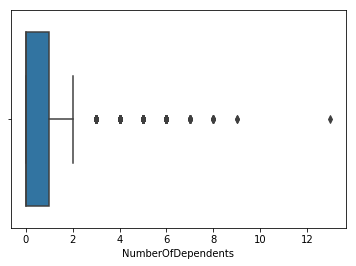

In [22]:
# 2. Explore Data
make_graphs(df, normal_qq_plots=False)

## Clean and preprocess data

In [23]:
# 3. Pre-Process and Clean Data
fill_missing(df)

## Generate Features/Predictors

In [24]:
# 4. Generate Features/Predictors

# one function that can discretize a continuous variable
# df = descretize_var(df, 'MonthlyIncome', 3)

# one function that can take a categorical
# variable and create binary/dummy variables from it.
# make_dummies(df, 'MonthlyIncome_discrete')

,PersonID,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,zipcode,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,MonthlyIncome_discrete,D_MonthlyIncome_discrete_1,D_MonthlyIncome_discrete_2,D_MonthlyIncome_discrete_3
0,98976,0,1.000000,55,60601,0,505.000000,0.0,2,0,0,0,0.0,1,1,0,0
1,98991,0,0.547745,71,60601,0,0.459565,15666.0,7,0,2,0,0.0,3,0,0,1
2,99012,0,0.044280,51,60601,0,0.014520,4200.0,5,0,0,0,0.0,1,1,0,0
3,99023,0,0.914249,55,60601,4,0.794875,9052.0,12,0,3,0,0.0,3,0,0,1
4,99027,0,0.026599,45,60601,0,0.049966,10406.0,4,0,0,0,2.0,3,0,0,1
5,99033,0,0.142231,57,60601,0,0.015332,13500.0,6,0,0,0,0.0,3,0,0,1
6,99044,0,0.047601,48,60601,0,0.474609,3583.0,13,0,1,0,1.0,1,1,0,0
7,99048,0,0.022141,34,60601,0,0.003332,2700.0,2,0,0,0,1.0,1,1,0,0
8,99056,0,0.241805,30,60601,0,0.864452,3400.0,13,0,1,0,1.0,1,1,0,0
9,99058,0,0.036181,71,60601,0,0.568798,5050.0,16,0,2,0,0.0,2,0,1,0


## Build and evaluate classifiers

In [ ]:
# Decision tree
run_tree_model(df,
               x_data=df[df.columns.difference(
                            ['PersonID',
                             'SeriousDlqin2yrs',
                             'zipcode',
                             'NumberOfTime60-89DaysPastDueNotWorse',
                             'NumberOfTimes90DaysLate'])],
               y_data=df['SeriousDlqin2yrs'],
               max_depth=5,
               outcome_labels=['Not Delinquent', 'Delinquent'])

In [ ]:
# Logit
run_logit_model(x_data=df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])],
                y_data=df['SeriousDlqin2yrs'], threshold=.25)

In [53]:
# Logit with different thresholds
logit_try_diff_thresholds(x_data=df[df.columns.difference(
                 ['PersonID',
                  'SeriousDlqin2yrs',
                  'zipcode',
                  'NumberOfTime60-89DaysPastDueNotWorse',
                  'NumberOfTimes90DaysLate'])],
                y_data=df['SeriousDlqin2yrs'], step=.05) 


Threshold is:  0.0 
 Score is:  0.1614004291008387 
 Percent true of negatives correctly identified:  0.0 
Percent of true positives erroneously labeled negative:  0.0 
Percent of true positives correctly identified:  100.0 
Percent of true negatives erroneously labeled positive:  519.58 



Threshold is:  0.05 
 Score is:  0.1861712502438073 
 Percent true of negatives correctly identified:  3.06 
Percent of true positives erroneously labeled negative:  0.11 
Percent of true positives correctly identified:  99.43 
Percent of true negatives erroneously labeled positive:  503.66 



Threshold is:  0.1 
 Score is:  0.41700799687926665 
 Percent true of negatives correctly identified:  32.08 
Percent of true positives erroneously labeled negative:  1.6 
Percent of true positives correctly identified:  91.71 
Percent of true negatives erroneously labeled positive:  352.92 



Threshold is:  0.15000000000000002 
 Score is:  0.6137604837136728 
 Percent true of negatives correctly identifie

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

'C:\\Users\\edwar.WJM-SONYLAPTOP\\Documents\\GitHub\\ML_spring_2019'